In [53]:
### Import Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pybaseball as pyb

In [54]:
# Define font properties for general text
font_properties = {'family': 'DejaVu Sans', 'size': 12}

# Define font properties for titles
font_properties_titles = {'family': 'DejaVu Sans', 'size': 20}

# Define font properties for axes labels
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}

# Set the theme for seaborn plots
sns.set_theme(style='whitegrid', 
              palette='deep', 
              font='DejaVu Sans', 
              font_scale=1.5, 
              color_codes=True, 
              rc=None)

# Import matplotlib
import matplotlib as mpl

# Set the resolution of the figures to 300 DPI
mpl.rcParams['figure.dpi'] = 300

In [55]:
print(pyb.playerid_lookup('Gore','Mackenzie'))

  name_last name_first  key_mlbam key_retro key_bbref  key_fangraphs  \
0      gore  mackenzie     669022  gorem001  gorema01          22201   

   mlb_played_first  mlb_played_last  
0            2022.0           2024.0  


In [56]:
pitcher_id = 669022
df_pyb = pyb.statcast_pitcher('2024-03-28', '2024-10-01', pitcher_id)
df_pyb.head()

Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
0,CH,2024-08-23,87.3,1.54,5.80,"Gore, MacKenzie",593160,669022,strikeout,called_strike,...,1,1,2,Standard,Standard,129.0,-0.061,-0.231,NaN,NaN
1,CU,2024-08-23,83.1,1.38,6.01,"Gore, MacKenzie",593160,669022,NaN,ball,...,1,1,2,Standard,Standard,332.0,0.019,0.024,NaN,NaN
2,CU,2024-08-23,83.4,1.33,5.99,"Gore, MacKenzie",593160,669022,NaN,swinging_strike_blocked,...,1,1,2,Standard,Standard,331.0,0.000,-0.047,56.48919,8.47257
3,CU,2024-08-23,79.4,1.45,5.90,"Gore, MacKenzie",593160,669022,NaN,swinging_strike,...,1,1,2,Standard,Standard,337.0,0.000,-0.042,48.85066,7.58196
4,CH,2024-08-23,86.0,1.77,5.92,"Gore, MacKenzie",657656,669022,single,hit_into_play,...,1,1,2,Standard,Standard,131.0,0.023,0.113,74.00396,7.75517


In [57]:
def df_processing(df_pyb: pd.DataFrame):
    df = df_pyb.copy()
    # Define the codes for different types of swings and whiffs
    swing_code = ['foul_bunt','foul','hit_into_play','swinging_strike', 'foul_tip',
                'swinging_strike_blocked','missed_bunt','bunt_foul_tip']
    whiff_code = ['swinging_strike', 'foul_tip', 'swinging_strike_blocked']

    # Create new columns in the DataFrame to indicate swing, whiff, in-zone, out-zone, and chase
    df['swing'] = (df['description'].isin(swing_code))
    df['whiff'] = (df['description'].isin(whiff_code))
    df['in_zone'] = (df['zone'] < 10)
    df['out_zone'] = (df['zone'] > 10)
    df['chase'] = (df.in_zone==False) & (df.swing == 1)

    # Convert the pitch type to a categorical variable
    df['pfx_z'] = df['pfx_z'] * 12
    df['pfx_x'] = df['pfx_x'] * 12
    return df

df = df_processing(df_pyb)

In [58]:
!wget -O statcast_2024_grouped.csv https://github.com/tnestico/pitching_summary/raw/main/statcast_2024_grouped.csv
df_statcast_group = pd.read_csv('statcast_2024_grouped.csv')

--2024-08-28 12:52:06--  https://github.com/tnestico/pitching_summary/raw/main/statcast_2024_grouped.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tnestico/pitching_summary/main/statcast_2024_grouped.csv [following]
--2024-08-28 12:52:06--  https://raw.githubusercontent.com/tnestico/pitching_summary/main/statcast_2024_grouped.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5432 (5.3K) [text/plain]
Saving to: ‘statcast_2024_grouped.csv’

statcast_2024_group 100%[===================>]   5.30K  --.-KB/s    in 0s      

2024-08-28 12:52:06 (19.2 MB/s) - ‘statcast_2024_grouped.csv’ saved [5

In [59]:
import math
import matplotlib.gridspec as gridspec

pitch_colours = {
    ## Fastballs ##
    'FF': {'colour': '#FF007D', 'name': '4-Seam Fastball'},
    'FA': {'colour': '#FF007D', 'name': 'Fastball'},
    'SI': {'colour': '#98165D', 'name': 'Sinker'},
    'FC': {'colour': '#BE5FA0', 'name': 'Cutter'},

    ## Offspeed ##
    'CH': {'colour': '#F79E70', 'name': 'Changeup'},
    'FS': {'colour': '#FE6100', 'name': 'Splitter'},
    'SC': {'colour': '#F08223', 'name': 'Screwball'},
    'FO': {'colour': '#FFB000', 'name': 'Forkball'},

    ## Sliders ##
    'SL': {'colour': '#67E18D', 'name': 'Slider'},
    'ST': {'colour': '#1BB999', 'name': 'Sweeper'},
    'SV': {'colour': '#376748', 'name': 'Slurve'},

    ## Curveballs ##
    'KC': {'colour': '#311D8B', 'name': 'Knuckle Curve'},
    'CU': {'colour': '#3025CE', 'name': 'Curveball'},
    'CS': {'colour': '#274BFC', 'name': 'Slow Curve'},
    'EP': {'colour': '#648FFF', 'name': 'Eephus'},

    ## Others ##
    'KN': {'colour': '#867A08', 'name': 'Knuckleball'},
    'PO': {'colour': '#472C30', 'name': 'Pitch Out'},
    'UN': {'colour': '#9C8975', 'name': 'Unknown'},
}



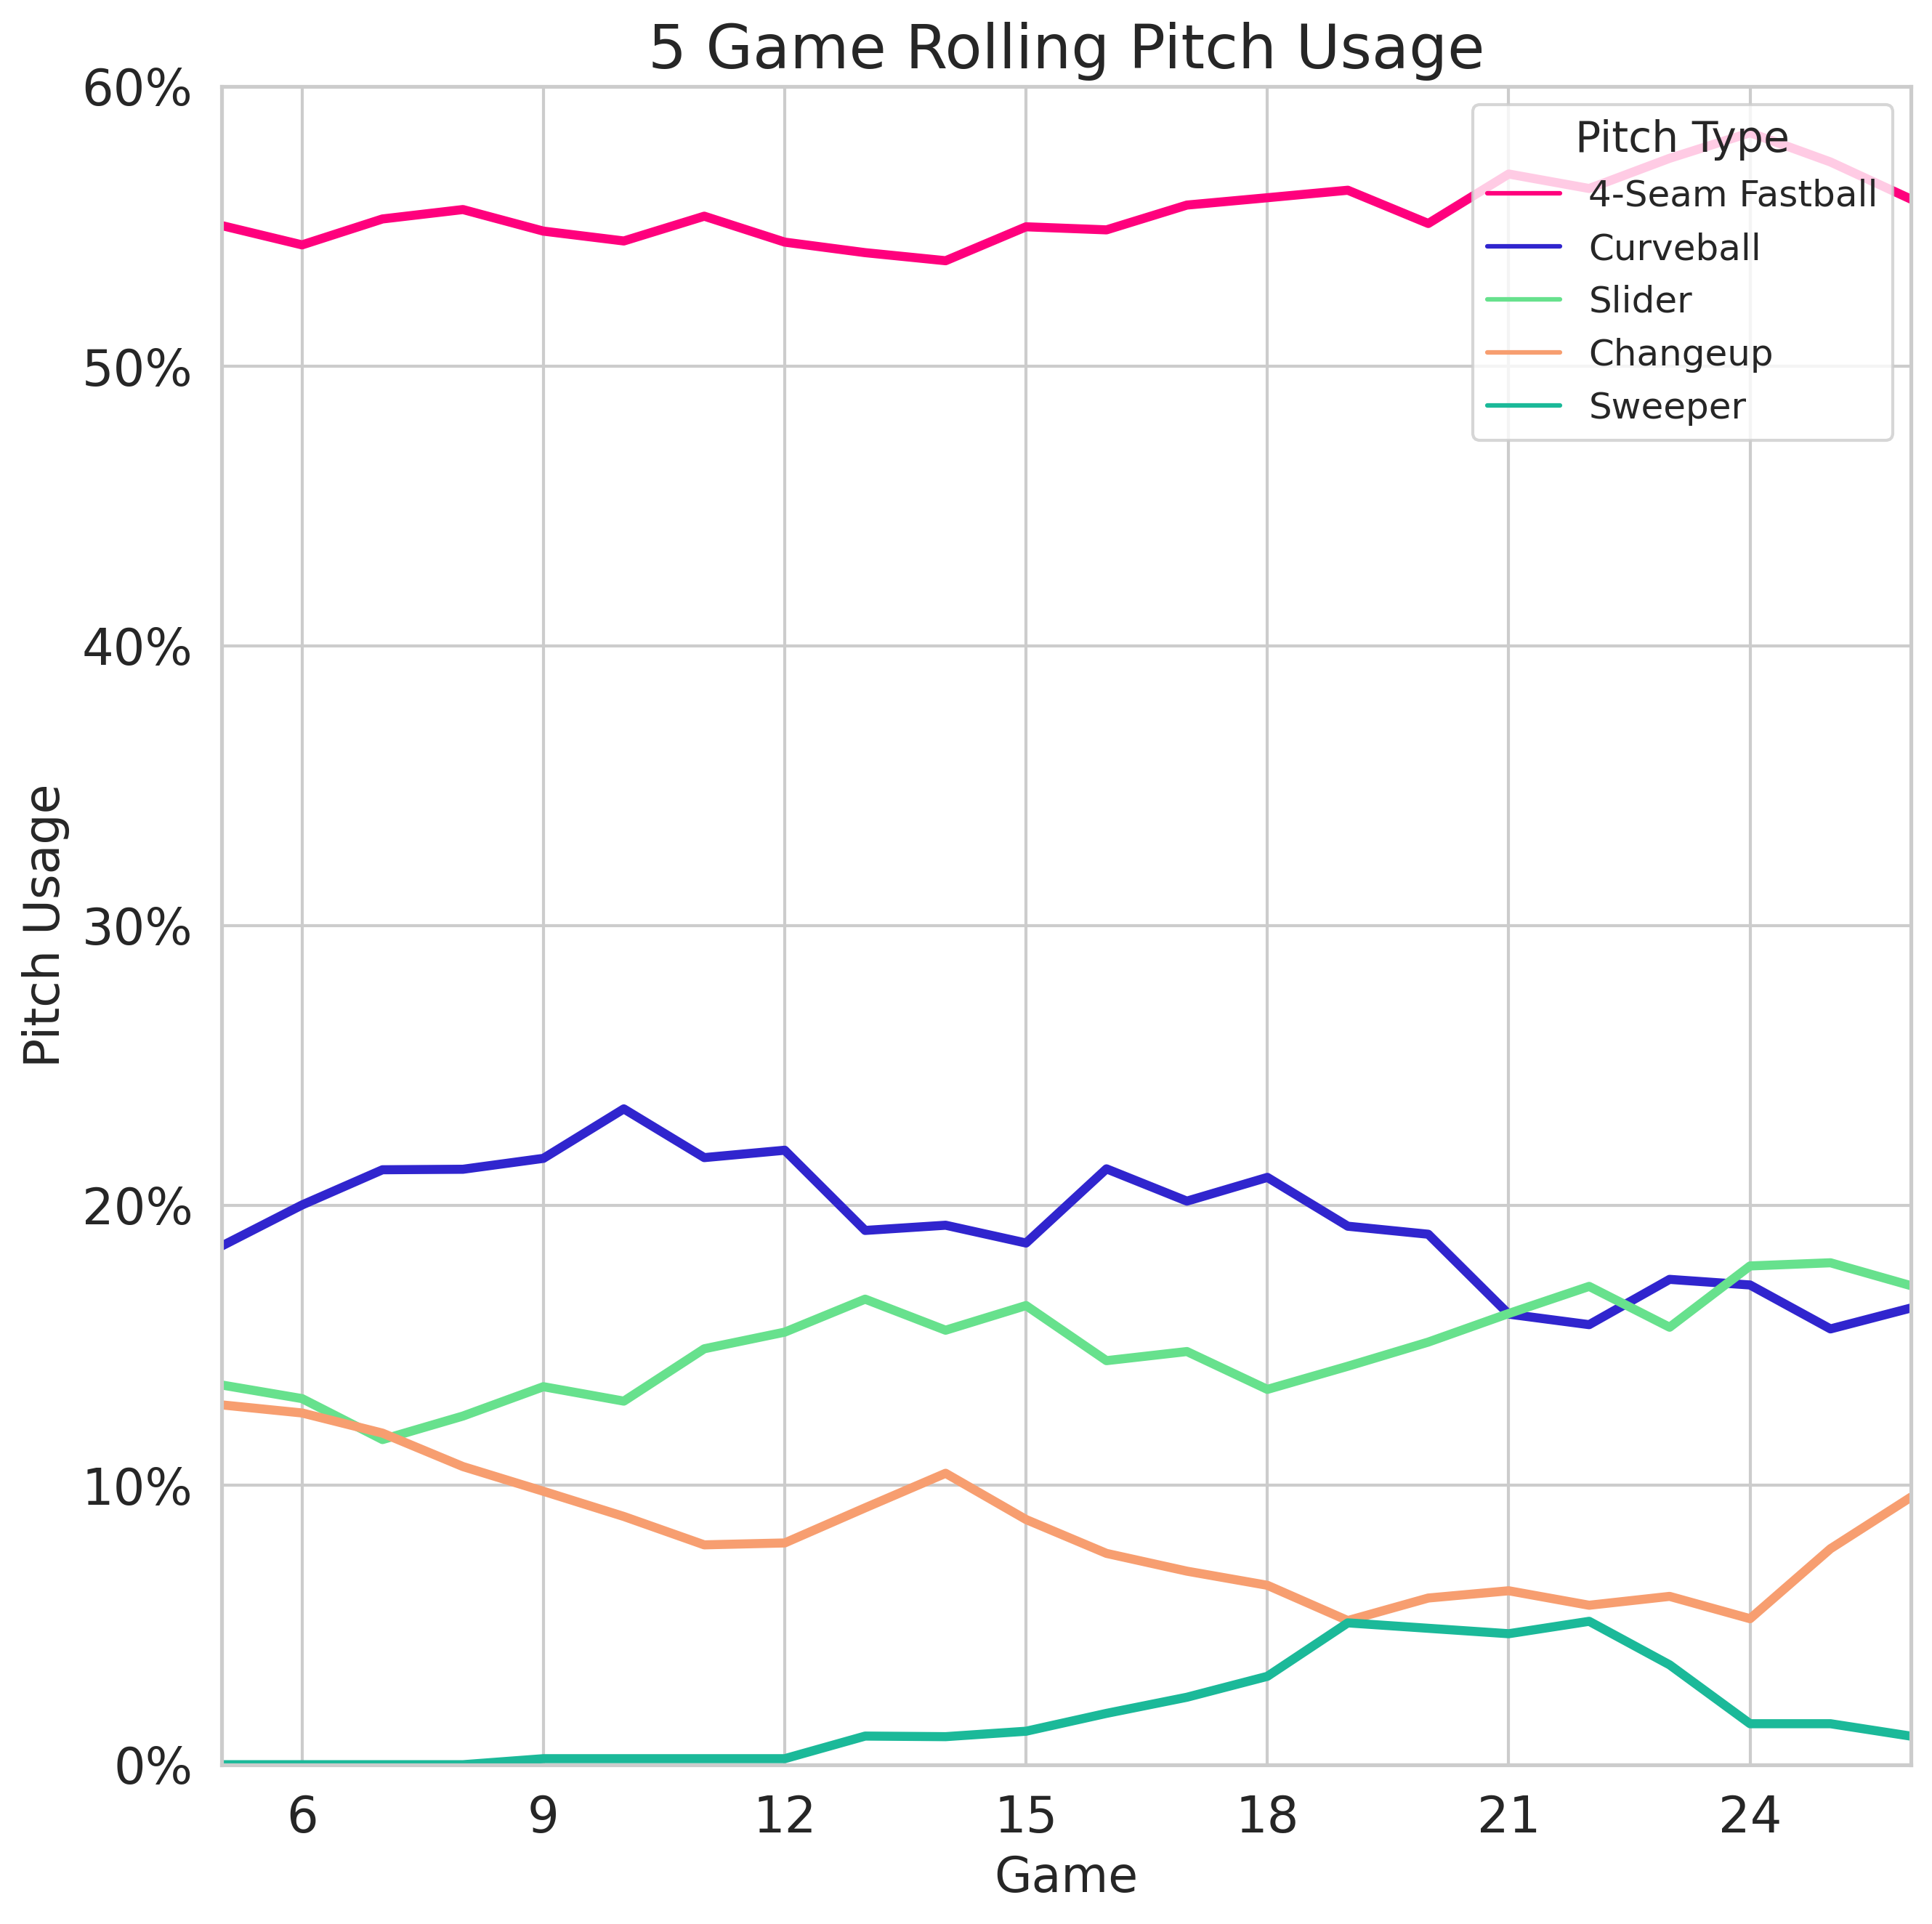

In [60]:
import matplotlib.lines as mlines

def rolling_pitch_usage(df: pd.DataFrame, ax: plt.Axes, window: int):
    # Calculate the proportion of each pitch type per game
    df_game_group = pd.DataFrame((df.groupby(['game_pk', 'game_date', 'pitch_type'])['release_speed'].count() /
                                  df.groupby(['game_pk', 'game_date'])['release_speed'].count()).reset_index())

    # Create a complete list of games
    all_games = pd.Series(df_game_group['game_pk'].unique())

    # Create a complete list of pitch types
    all_pitch_types = pd.Series(df_game_group['pitch_type'].unique())

    # Create a DataFrame with all combinations of games and pitch types
    all_combinations = pd.MultiIndex.from_product([all_games, all_pitch_types], names=['game_pk', 'pitch_type']).to_frame(index=False)

    # Merge this DataFrame with your original DataFrame to ensure all combinations are included
    df_complete = pd.merge(all_combinations, df_game_group, on=['game_pk', 'pitch_type'], how='left')

    # Fill missing values with 0
    df_complete['release_speed'] = df_complete['release_speed'].fillna(0)

    # Create mappings for game numbers and game dates
    game_list = df.sort_values(by='game_date')['game_pk'].unique()
    range_list = list(range(1, len(game_list) + 1))
    game_to_range = dict(zip(game_list, range_list))
    game_to_date = df.set_index('game_pk')['game_date'].to_dict()

    # Map game dates and game numbers to the complete DataFrame
    df_complete['game_date'] = df_complete['game_pk'].map(game_to_date)
    df_complete = df_complete.sort_values(by='game_date')
    df_complete['game_number'] = df_complete['game_pk'].map(game_to_range)

    # Initialize a list to hold the Line2D objects and their corresponding labels
    lines = []

    # Plot the rolling pitch usage for each pitch type
    sorted_value_counts = df['pitch_type'].value_counts().sort_values(ascending=False)
    items_in_order = sorted_value_counts.index.tolist()
    max_roll = []

    for i in items_in_order:
        line, = ax.plot(
            range(1, max(df_complete[df_complete['pitch_type'] == i]['game_number']) + 1),
            df_complete[df_complete['pitch_type'] == i]['release_speed'].rolling(window).sum() / window,
            color=pitch_colours[i]['colour'], linewidth=3
        )
        lines.append(mlines.Line2D([], [], color=pitch_colours[i]['colour'], label=pitch_colours[i]['name']))
        max_roll.append(np.max(df_complete[df_complete['pitch_type'] == i]['release_speed'].rolling(window).sum() / window))

    # Adjust x-axis limits to start from the window size
    ax.set_xlim(window, len(game_list))
    ax.set_ylim(0, math.ceil(max(max_roll) * 10) / 10)

    # Set axis labels and title
    ax.set_xlabel('Game', fontdict=font_properties_axes)
    ax.set_ylabel('Pitch Usage', fontdict=font_properties_axes)
    ax.set_title(f"{window} Game Rolling Pitch Usage", fontdict=font_properties_titles)

    # Set x-axis to show integer values only
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Set y-axis ticks as percentages
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    # Add the legend to the plot manually
    ax.legend(handles=lines, title='Pitch Type', loc='upper right', fontsize=12, title_fontsize=14)

# Example usage:
fig, ax = plt.subplots(figsize=(10, 10))
rolling_pitch_usage(df, ax=ax, window=5)
plt.show()
